In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RNN
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Astrazeneca GRU-SGD

In [14]:
df = pd.read_excel('/content/drive/MyDrive/Astrazeneca_MiningYoutubeconcat_preprocess3_6Juli EXCEL.xlsx')
df = df[~df['Comments'].isnull()]
df = df.reset_index()
df = df.drop(['index'], axis=1)
df['sentimen']= df['sentimen'].fillna(4)
df_untagged = df[df['sentimen'] == 4]
df = df[df['sentimen'] != 4]
df

,Username,Comments,sentimen
0,rahmat hidayat,w aja abis vaksin az merasa mau lewat karna s...,0.0
1,muhammad angga,baru baru ini ada lagi korban meninggal karena...,-1.0
2,danu setiaji,coba kalian liat di yt vaksin astrazena di aus...,0.0
3,jay peseq8,di taiwan juga ada yg meninggal setelah di vak...,0.0
4,desi maulidia,saya punya riwayat jantung koroner tapi boleh2...,-1.0
...,...,...,...
245,ruslan abdulghani,ada lapuran dari seluruh dunia vaksin astrazen...,-1.0
246,eki yuniarti,harus dipelajari vaksin astrazeneca ini tidak ...,0.0
247,debby boris,netizen budiman vaksin astrazeneca ada beberap...,0.0
248,jasmine brown,saya punya husbands di england dia sudah vacci...,1.0


In [15]:
df_untagged = df_untagged.reset_index()
df_untagged = df_untagged.drop(['index'], axis=1)
df_untagged

,Username,Comments,sentimen
0,amelia furniture,benar dan nyata pernyataan bu ribka ciptaning ...,4.0
1,diana sumba sbd,majikan dan kawan sy juga sdh vaksin astrazene...,4.0
2,main free fire,banyak bonus dan hadiah banyak dari amerika se...,4.0
3,popon fatima,saya jdi takut mendengar seperti yg trjdi saat...,4.0
4,fokus medilong,astrazeneca merupakan vaksin yg paling berbaha...,4.0
...,...,...,...
79,zona_viral,yg saya mau tuh setelah divaksin negara indone...,4.0
80,zulkarnaini 2207,yang mau vaksin silahkankita dukung tapi yang ...,4.0
81,dewi aja,rakyat tak sebodoh kalian tikus2 berdasiizin h...,4.0
82,davidâ€¢gym_21,hnya org bodo yg mau divaksin aku pribadi az ...,4.0


In [16]:
print(df.sentimen.value_counts())

 1.0    104
-1.0     97
 0.0     49
Name: sentimen, dtype: int64


In [17]:
df['POS']= np.where(df['sentimen'] == 1, '1', '0')
df['NET']= np.where(df['sentimen'] == 0, '1', '0')
df['NEG']= np.where(df['sentimen'] == -1, '1', '0')
df = df.drop(['sentimen'], axis=1)
df

,Username,Comments,POS,NET,NEG
0,rahmat hidayat,w aja abis vaksin az merasa mau lewat karna s...,0,1,0
1,muhammad angga,baru baru ini ada lagi korban meninggal karena...,0,0,1
2,danu setiaji,coba kalian liat di yt vaksin astrazena di aus...,0,1,0
3,jay peseq8,di taiwan juga ada yg meninggal setelah di vak...,0,1,0
4,desi maulidia,saya punya riwayat jantung koroner tapi boleh2...,0,0,1
...,...,...,...,...,...
245,ruslan abdulghani,ada lapuran dari seluruh dunia vaksin astrazen...,0,0,1
246,eki yuniarti,harus dipelajari vaksin astrazeneca ini tidak ...,0,1,0
247,debby boris,netizen budiman vaksin astrazeneca ada beberap...,0,1,0
248,jasmine brown,saya punya husbands di england dia sudah vacci...,1,0,0


In [18]:
#ilangin link dan uname
df["Comments"]=df["Comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df["Comments"]=df["Comments"].str.lower()
#ilangin simbol
df["Comments"]=df["Comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df["Comments"]=df["Comments"].str.replace('\d+',' ')
#ilangin enter
df["Comments"]=df["Comments"].str.replace('\n',' ',regex=True)
df["Comments"] = df["Comments"].replace('\s+', ' ', regex=True)
df

,Username,Comments,POS,NET,NEG
0,rahmat hidayat,w aja abis vaksin az merasa mau lewat karna sa...,0,1,0
1,muhammad angga,baru baru ini ada lagi korban meninggal karena...,0,0,1
2,danu setiaji,coba kalian liat di yt vaksin astrazena di aus...,0,1,0
3,jay peseq8,di taiwan juga ada yg meninggal setelah di vak...,0,1,0
4,desi maulidia,saya punya riwayat jantung koroner tapi boleh ...,0,0,1
...,...,...,...,...,...
245,ruslan abdulghani,ada lapuran dari seluruh dunia vaksin astrazen...,0,0,1
246,eki yuniarti,harus dipelajari vaksin astrazeneca ini tidak ...,0,1,0
247,debby boris,netizen budiman vaksin astrazeneca ada beberap...,0,1,0
248,jasmine brown,saya punya husbands di england dia sudah vacci...,1,0,0


In [19]:
df_majority = df[df.NET== '0' ]

df_minority = df[df.NET== '1']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=104,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.NEG== '0' ]

df_minority_2 = df_upsampled[df_upsampled.NEG== '1']

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=104,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
df = df_upsampled_2
print(df.POS.value_counts())
print(df.NET.value_counts())
print(df.NEG.value_counts())

0    208
1    104
Name: POS, dtype: int64
0    208
1    104
Name: NET, dtype: int64
0    208
1    104
Name: NEG, dtype: int64


In [20]:
df['POS']=df['POS'].astype(int)
df['NET']=df['NET'].astype(int)
df['NEG']=df['NEG'].astype(int)
train, test = train_test_split(df, test_size=0.2, random_state = 23)
list_classes = ['POS','NET','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["Comments"]
list_sentences_test = test["Comments"]
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [21]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [22]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [23]:
word_vectors = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/model300.bin",binary="True", unicode_errors='ignore')
word2vec = word_vectors
embed_dim = 300

In [24]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

1081 284
known words: 1081
unknown words: 284


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [25]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
inp = Input(shape=(maxlen,))


In [55]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
#x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 - 5s - loss: 0.7273 - accuracy: 0.3173 - val_loss: 0.6743 - val_accuracy: 0.2063

 ROC-AUC - epoch: 1 - score: 0.370006 

Epoch 2/100
8/8 - 1s - loss: 0.6904 - accuracy: 0.3293 - val_loss: 0.6626 - val_accuracy: 0.2540

 ROC-AUC - epoch: 2 - score: 0.435737 

Epoch 3/100
8/8 - 1s - loss: 0.6920 - accuracy: 0.2932 - val_loss: 0.6476 - val_accuracy: 0.2857

 ROC-AUC - epoch: 3 - score: 0.508033 

Epoch 4/100
8/8 - 1s - loss: 0.6817 - accuracy: 0.3092 - val_loss: 0.6442 - val_accuracy: 0.3333

 ROC-AUC - epoch: 4 - score: 0.543704 

Epoch 5/100
8/8 - 1s - loss: 0.6638 - accuracy: 0.3454 - val_loss: 0.6319 - val_accuracy: 0.4286

 ROC-AUC - epoch: 5 - score: 0.606197 

Epoch 6/100
8/8 - 1s - loss: 0.6554 - accuracy: 0.3373 - val_loss: 0.6243 - val_accuracy: 0.5714

 ROC-AUC - epoch: 6 - score: 0.660336 

Epoch 7/100
8/8 - 1s - loss: 0.6552 - accuracy: 0.3815 - val_loss: 0.6220 - val_accuracy: 0.5873

 ROC-AUC - epoch: 7 - score: 0.663895 

Epoch 8/100
8/8 - 1s - loss: 0.642

In [56]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           409800    
_________________________________________________________________
gru_1 (GRU)                  (None, 50, 200)           301200    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 200)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0   

In [57]:
from keras.models import load_model
c = model.predict(X_te)

In [58]:

score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 47ms/step - loss: 0.4325 - accuracy: 0.7302
Test accuracy: 0.7301587462425232


In [59]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.8533667872563893

In [60]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

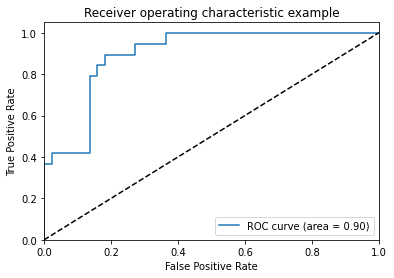

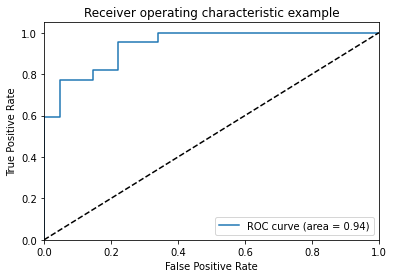

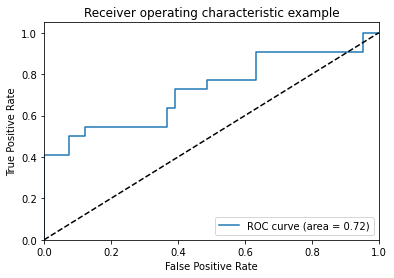

In [61]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [62]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)


0.754901388726806

In [63]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[30 14]
  [ 1 18]]

 [[35  6]
  [ 4 18]]

 [[28 13]
  [10 12]]]
              precision    recall  f1-score   support

           0       0.56      0.95      0.71        19
           1       0.75      0.82      0.78        22
           2       0.48      0.55      0.51        22

   micro avg       0.59      0.76      0.67        63
   macro avg       0.60      0.77      0.67        63
weighted avg       0.60      0.76      0.66        63
 samples avg       0.65      0.76      0.69        63



In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.6507936507936508


In [66]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.5396825396825397
Hamming loss: 0.25396825396825395


In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[18,  0,  1],
       [ 3, 18,  1],
       [11,  4,  7]])

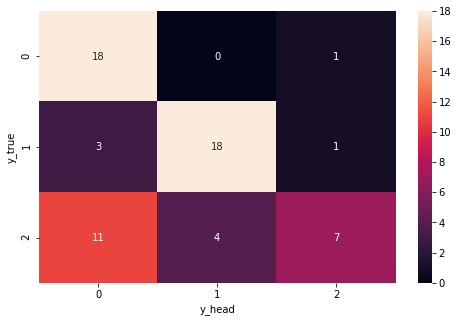

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

#Astrazeneca LSTM-ADAM

In [39]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = LSTM(200, activation='tanh', return_sequences = True, dropout=0.4)(x)
#x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="softmax")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 - 7s - loss: 0.6605 - accuracy: 0.3735 - val_loss: 0.6108 - val_accuracy: 0.4603

 ROC-AUC - epoch: 1 - score: 0.782267 

Epoch 2/100
8/8 - 2s - loss: 0.6475 - accuracy: 0.3936 - val_loss: 0.5697 - val_accuracy: 0.4762

 ROC-AUC - epoch: 2 - score: 0.811899 

Epoch 3/100
8/8 - 2s - loss: 0.6035 - accuracy: 0.4538 - val_loss: 0.5460 - val_accuracy: 0.5714

 ROC-AUC - epoch: 3 - score: 0.850430 

Epoch 4/100
8/8 - 2s - loss: 0.5680 - accuracy: 0.5341 - val_loss: 0.5080 - val_accuracy: 0.5556

 ROC-AUC - epoch: 4 - score: 0.848815 

Epoch 5/100
8/8 - 2s - loss: 0.5604 - accuracy: 0.5743 - val_loss: 0.4818 - val_accuracy: 0.6508

 ROC-AUC - epoch: 5 - score: 0.844721 

Epoch 6/100
8/8 - 2s - loss: 0.5459 - accuracy: 0.5823 - val_loss: 0.4752 - val_accuracy: 0.6190

 ROC-AUC - epoch: 6 - score: 0.883222 

Epoch 7/100
8/8 - 2s - loss: 0.4949 - accuracy: 0.6466 - val_loss: 0.4501 - val_accuracy: 0.6825

 ROC-AUC - epoch: 7 - score: 0.875345 

Epoch 8/100
8/8 - 2s - loss: 0.448

In [40]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 300)           409800    
_________________________________________________________________
lstm (LSTM)                  (None, 50, 200)           400800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0   

In [41]:
from keras.models import load_model
c = model.predict(X_te)

In [42]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 57ms/step - loss: 1.6535 - accuracy: 0.6667
Test accuracy: 0.6666666865348816


In [43]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.8651534601470418

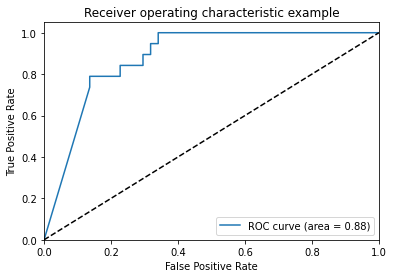

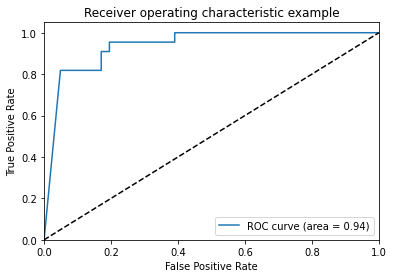

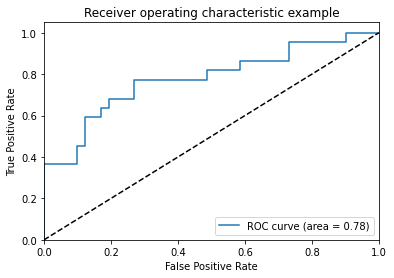

In [44]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [45]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)



0.7561996732407517

In [46]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[31 13]
  [ 2 17]]

 [[35  6]
  [ 4 18]]

 [[37  4]
  [14  8]]]
              precision    recall  f1-score   support

           0       0.57      0.89      0.69        19
           1       0.75      0.82      0.78        22
           2       0.67      0.36      0.47        22

   micro avg       0.65      0.68      0.67        63
   macro avg       0.66      0.69      0.65        63
weighted avg       0.67      0.68      0.65        63
 samples avg       0.67      0.68      0.68        63



In [47]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.6746031746031746


In [48]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.6666666666666666
Hamming loss: 0.2275132275132275


In [49]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[17,  0,  2],
       [ 4, 18,  0],
       [ 9,  5,  8]])

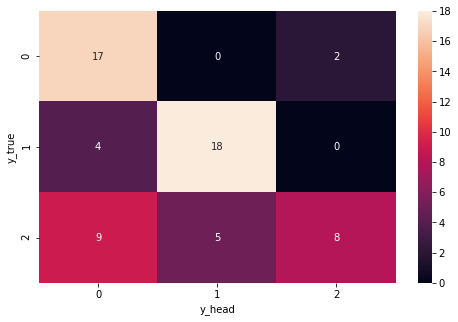

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [52]:
df_untagged = df_untagged.drop(['sentimen'], axis =1)
df_untagged

,Username,Comments
0,amelia furniture,benar dan nyata pernyataan bu ribka ciptaning ...
1,diana sumba sbd,majikan dan kawan sy juga sdh vaksin astrazene...
2,main free fire,banyak bonus dan hadiah banyak dari amerika se...
3,popon fatima,saya jdi takut mendengar seperti yg trjdi saat...
4,fokus medilong,astrazeneca merupakan vaksin yg paling berbaha...
...,...,...
79,zona_viral,yg saya mau tuh setelah divaksin negara indone...
80,zulkarnaini 2207,yang mau vaksin silahkankita dukung tapi yang ...
81,dewi aja,rakyat tak sebodoh kalian tikus2 berdasiizin h...
82,davidâ€¢gym_21,hnya org bodo yg mau divaksin aku pribadi az ...


In [53]:
#ilangin link dan uname
df_untagged["Comments"]=df_untagged["Comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df_untagged["Comments"]=df_untagged["Comments"].str.lower()
#ilangin simbol
df_untagged["Comments"]=df_untagged["Comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df_untagged["Comments"]=df_untagged["Comments"].str.replace('\d+',' ')
#ilangin enter
df_untagged["Comments"]=df_untagged["Comments"].str.replace('\n',' ',regex=True)
df_untagged["Comments"] = df_untagged["Comments"].replace('\s+', ' ', regex=True)
df_untagged

,Username,Comments
0,amelia furniture,benar dan nyata pernyataan bu ribka ciptaning ...
1,diana sumba sbd,majikan dan kawan sy juga sdh vaksin astrazene...
2,main free fire,banyak bonus dan hadiah banyak dari amerika se...
3,popon fatima,saya jdi takut mendengar seperti yg trjdi saat...
4,fokus medilong,astrazeneca merupakan vaksin yg paling berbaha...
...,...,...
79,zona_viral,yg saya mau tuh setelah divaksin negara indone...
80,zulkarnaini 2207,yang mau vaksin silahkankita dukung tapi yang ...
81,dewi aja,rakyat tak sebodoh kalian tikus berdasiizin ha...
82,davidâ€¢gym_21,hnya org bodo yg mau divaksin aku pribadi az g...


In [54]:
list_sentences_aplikasi = df_untagged["Comments"]
list_tokenized_aplikasi = tokenizer.texts_to_sequences(list_sentences_aplikasi)
X_aplikasi = pad_sequences(list_tokenized_aplikasi, maxlen=maxlen)
X_aplikasi

array([[   0,    0,    0, ...,    6,  772,   10],
       [   0,    0,    0, ...,  668,    1,  396],
       [   0,    0,    0, ...,   51, 1215,  964],
       ...,
       [  94,  196,  303, ...,    2,  171,  331],
       [   0,    0,    0, ...,  140,    1, 1238],
       [ 834,  396,  525, ...,    2,  305,  208]], dtype=int32)

In [69]:
y_pred_aplikasi = model.predict(X_aplikasi)
y_pred_aplikasi


array([[0.28036618, 0.12128386, 0.5193308 ],
       [0.88450146, 0.03519848, 0.02826834],
       [0.31601194, 0.1867499 , 0.27221674],
       [0.84652907, 0.02304843, 0.13005921],
       [0.27634245, 0.0910911 , 0.53699124],
       [0.2684561 , 0.31642914, 0.18650752],
       [0.13781625, 0.6387254 , 0.09040186],
       [0.5984266 , 0.25791305, 0.04077572],
       [0.63815325, 0.08485547, 0.11904401],
       [0.10131118, 0.2905715 , 0.3559412 ],
       [0.5649011 , 0.03162718, 0.3388884 ],
       [0.91606444, 0.12244901, 0.02960607],
       [0.40254974, 0.06009099, 0.5213441 ],
       [0.31087184, 0.11639315, 0.23503232],
       [0.90352005, 0.04678619, 0.01704368],
       [0.17851523, 0.11995578, 0.5759027 ],
       [0.5173751 , 0.0492458 , 0.22483459],
       [0.38284734, 0.21429154, 0.21854493],
       [0.3003239 , 0.07070121, 0.19190395],
       [0.5852002 , 0.05442324, 0.2768656 ],
       [0.80207455, 0.02796152, 0.271456  ],
       [0.32025284, 0.03975695, 0.6027491 ],
       [0.

In [70]:
dfhasil = pd.DataFrame(y_pred_aplikasi, columns=['POS', 'NET', 'NEG'])
dfhasil

,POS,NET,NEG
0,0.280366,0.121284,0.519331
1,0.884501,0.035198,0.028268
2,0.316012,0.186750,0.272217
3,0.846529,0.023048,0.130059
4,0.276342,0.091091,0.536991
...,...,...,...
79,0.495090,0.019959,0.470877
80,0.129433,0.399930,0.246330
81,0.475747,0.019897,0.545499
82,0.046990,0.558062,0.373799


In [71]:
dfhasilramal = dfhasil.eq(dfhasil.where(dfhasil != 0).max(1), axis=0).astype(int)
dfhasilramal

,POS,NET,NEG
0,0,0,1
1,1,0,0
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
79,1,0,0
80,0,1,0
81,0,0,1
82,0,1,0


In [72]:
finalresult = pd.concat([df_untagged, dfhasilramal], axis=1, sort=False)
finalresult

,Username,Comments,POS,NET,NEG
0,amelia furniture,benar dan nyata pernyataan bu ribka ciptaning ...,0,0,1
1,diana sumba sbd,majikan dan kawan sy juga sdh vaksin astrazene...,1,0,0
2,main free fire,banyak bonus dan hadiah banyak dari amerika se...,1,0,0
3,popon fatima,saya jdi takut mendengar seperti yg trjdi saat...,1,0,0
4,fokus medilong,astrazeneca merupakan vaksin yg paling berbaha...,0,0,1
...,...,...,...,...,...
79,zona_viral,yg saya mau tuh setelah divaksin negara indone...,1,0,0
80,zulkarnaini 2207,yang mau vaksin silahkankita dukung tapi yang ...,0,1,0
81,dewi aja,rakyat tak sebodoh kalian tikus berdasiizin ha...,0,0,1
82,davidâ€¢gym_21,hnya org bodo yg mau divaksin aku pribadi az g...,0,1,0


In [73]:
finalresult.POS.value_counts()

1    43
0    41
Name: POS, dtype: int64

In [74]:
finalresult.NET.value_counts()

0    61
1    23
Name: NET, dtype: int64

In [75]:
finalresult.NEG.value_counts()

0    66
1    18
Name: NEG, dtype: int64

#Sinovac GRU-SGD

In [85]:
df = pd.read_excel('/content/drive/MyDrive/Sinovac_MiningYoutubeconcat_preprocess3_6Juli EXCEL.xlsx')
df = df[~df['comments'].isnull()]
df = df.reset_index()
df = df.drop(['index'], axis=1)
df['sentimen']= df['sentimen'].fillna(4)
df_untagged = df[df['sentimen'] == 4]
df = df[df['sentimen'] != 4]
df

,username,comments,sentimen
0,é­ æ˜Ž ç™¼,saya habis vaksin sinovac kena sesak nafas uda...,0.0
1,opet markopet,meninggal habis vaksin sinovac 1 karena udah ...,1.0
2,singgih pratama,saya hari ini baru di vaksin sinovac aman bos ...,1.0
3,alam semesta,bagaimana kelanjutan vaksin sinovac apa dilanj...,-1.0
4,masfap tv,gwa baru di vaksin sinovac doain semoga ga ken...,0.0
...,...,...,...
245,red dragon,kakakku selepas divaksin sinovac malah kena ra...,-1.0
246,yulidasetia ningsih,sinovac kan dari cina kok mau ya,-1.0
247,fetria,semoga gak ada acara pemaksaan divaksin ya kh...,-1.0
248,yeni susana,sinovac dari chinasedangkan dichina aja blm me...,-1.0


In [86]:
df_untagged = df_untagged.reset_index()
df_untagged = df_untagged.drop(['index'], axis=1)
df_untagged

,username,comments,sentimen
0,amsaff s,antara sinovac who cepi bill gates and melinda...,4.0
1,furink kucink,betul vaksin sinovac kah yang di suntikkan,4.0
2,fian rubianti,itu kalo udh disuntik vaksin sinovac nya masih...,4.0
3,saleh sj,benarkah dan kenapa bbrp negara lain byk yg me...,4.0
4,suhudan nasution,pak tolong d vaksin lebih dulu sabu janda deny...,4.0
5,evy avrianty,dokter2 dunia mengatakan vaksinsinovacpfizermo...,4.0
6,iwan ris,dichina aja sinovac ga d pakeko malah di pake ...,4.0
7,holidy bilal alki,ini ril modus koruptor beli faxin sinovax,4.0
8,hero hero,mengapa vaksin sinovac sudah disuntikkan kepad...,4.0
9,jeka chenel,ada yg janggal dgn berita ini vaksin sinovak ...,4.0


In [87]:
print(df.sentimen.value_counts())

-1.0    100
 1.0     91
 0.0     59
Name: sentimen, dtype: int64


In [88]:
df['POS']= np.where(df['sentimen'] == 1, '1', '0')
df['NET']= np.where(df['sentimen'] == 0, '1', '0')
df['NEG']= np.where(df['sentimen'] == -1, '1', '0')
df = df.drop(['sentimen'], axis=1)
df

,username,comments,POS,NET,NEG
0,é­ æ˜Ž ç™¼,saya habis vaksin sinovac kena sesak nafas uda...,0,1,0
1,opet markopet,meninggal habis vaksin sinovac 1 karena udah ...,1,0,0
2,singgih pratama,saya hari ini baru di vaksin sinovac aman bos ...,1,0,0
3,alam semesta,bagaimana kelanjutan vaksin sinovac apa dilanj...,0,0,1
4,masfap tv,gwa baru di vaksin sinovac doain semoga ga ken...,0,1,0
...,...,...,...,...,...
245,red dragon,kakakku selepas divaksin sinovac malah kena ra...,0,0,1
246,yulidasetia ningsih,sinovac kan dari cina kok mau ya,0,0,1
247,fetria,semoga gak ada acara pemaksaan divaksin ya kh...,0,0,1
248,yeni susana,sinovac dari chinasedangkan dichina aja blm me...,0,0,1


In [89]:
#ilangin link dan uname
df["comments"]=df["comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df["comments"]=df["comments"].str.lower()
#ilangin simbol
df["comments"]=df["comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df["comments"]=df["comments"].str.replace('\d+',' ')
#ilangin enter
df["comments"]=df["comments"].str.replace('\n',' ',regex=True)
df["comments"] = df["comments"].replace('\s+', ' ', regex=True)
df

,username,comments,POS,NET,NEG
0,é­ æ˜Ž ç™¼,saya habis vaksin sinovac kena sesak nafas uda...,0,1,0
1,opet markopet,meninggal habis vaksin sinovac karena udah aja...,1,0,0
2,singgih pratama,saya hari ini baru di vaksin sinovac aman bos ...,1,0,0
3,alam semesta,bagaimana kelanjutan vaksin sinovac apa dilanj...,0,0,1
4,masfap tv,gwa baru di vaksin sinovac doain semoga ga ken...,0,1,0
...,...,...,...,...,...
245,red dragon,kakakku selepas divaksin sinovac malah kena ra...,0,0,1
246,yulidasetia ningsih,sinovac kan dari cina kok mau ya,0,0,1
247,fetria,semoga gak ada acara pemaksaan divaksin ya kha...,0,0,1
248,yeni susana,sinovac dari chinasedangkan dichina aja blm me...,0,0,1


In [90]:
df_majority = df[df.NET== '0' ]

df_minority = df[df.NET== '1']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=100,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.POS== '0' ]

df_minority_2 = df_upsampled[df_upsampled.POS== '1']

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=100,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
df = df_upsampled_2
print(df.POS.value_counts())
print(df.NET.value_counts())
print(df.NEG.value_counts())

0    200
1    100
Name: POS, dtype: int64
0    200
1    100
Name: NET, dtype: int64
0    200
1    100
Name: NEG, dtype: int64


In [92]:
df['POS']=df['POS'].astype(int)
df['NET']=df['NET'].astype(int)
df['NEG']=df['NEG'].astype(int)
train, test = train_test_split(df, test_size=0.2, random_state = 23)
list_classes = ['POS','NET','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["comments"]
list_sentences_test = test["comments"]
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [93]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [94]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [95]:
word_vectors = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/model300.bin",binary="True", unicode_errors='ignore')
word2vec = word_vectors
embed_dim = 300

In [96]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

1271 308
known words: 1271
unknown words: 308


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [97]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
inp = Input(shape=(maxlen,))


In [98]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
#x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 - 5s - loss: 0.6798 - accuracy: 0.3792 - val_loss: 0.6607 - val_accuracy: 0.3833

 ROC-AUC - epoch: 1 - score: 0.476517 

Epoch 2/100
8/8 - 1s - loss: 0.6710 - accuracy: 0.3583 - val_loss: 0.6560 - val_accuracy: 0.3167

 ROC-AUC - epoch: 2 - score: 0.482464 

Epoch 3/100
8/8 - 1s - loss: 0.6465 - accuracy: 0.4083 - val_loss: 0.6488 - val_accuracy: 0.3000

 ROC-AUC - epoch: 3 - score: 0.491275 

Epoch 4/100
8/8 - 1s - loss: 0.6448 - accuracy: 0.4292 - val_loss: 0.6567 - val_accuracy: 0.3000

 ROC-AUC - epoch: 4 - score: 0.472681 

Epoch 5/100
8/8 - 1s - loss: 0.6581 - accuracy: 0.4000 - val_loss: 0.6481 - val_accuracy: 0.3333

 ROC-AUC - epoch: 5 - score: 0.492562 

Epoch 6/100
8/8 - 1s - loss: 0.6540 - accuracy: 0.3875 - val_loss: 0.6476 - val_accuracy: 0.2667

 ROC-AUC - epoch: 6 - score: 0.495191 

Epoch 7/100
8/8 - 1s - loss: 0.6622 - accuracy: 0.3667 - val_loss: 0.6494 - val_accuracy: 0.2833

 ROC-AUC - epoch: 7 - score: 0.492310 

Epoch 8/100
8/8 - 1s - loss: 0.621

In [99]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           474000    
_________________________________________________________________
gru_2 (GRU)                  (None, 50, 200)           301200    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0   

In [100]:
from keras.models import load_model
c = model.predict(X_te)

In [101]:

score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 49ms/step - loss: 0.4690 - accuracy: 0.6667
Test accuracy: 0.6666666865348816


In [102]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.832030723905724

In [103]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

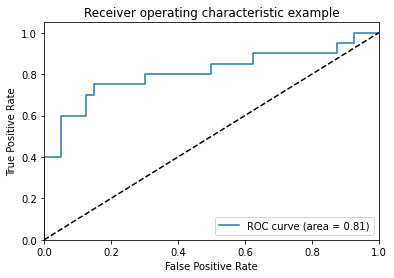

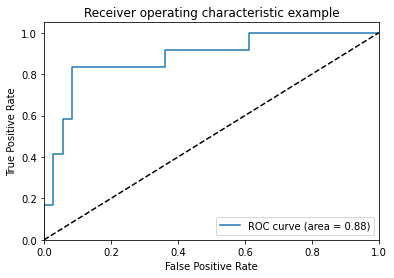

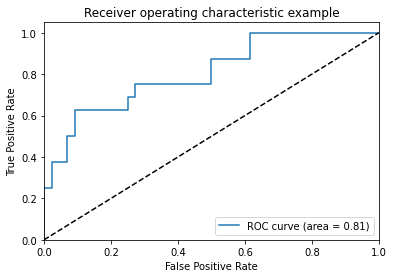

In [104]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [105]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)


0.7311447811447812

In [106]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[21 19]
  [ 4 16]]

 [[22 14]
  [ 2 22]]

 [[40  4]
  [ 6 10]]]
              precision    recall  f1-score   support

           0       0.46      0.80      0.58        20
           1       0.61      0.92      0.73        24
           2       0.71      0.62      0.67        16

   micro avg       0.56      0.80      0.66        60
   macro avg       0.59      0.78      0.66        60
weighted avg       0.59      0.80      0.67        60
 samples avg       0.64      0.80      0.69        60



In [107]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.6388888888888888


In [108]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.48333333333333334
Hamming loss: 0.2722222222222222


In [109]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[16,  2,  2],
       [12, 12,  0],
       [ 7,  1,  8]])

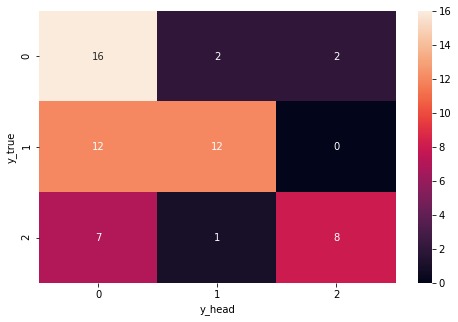

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

#Sinovac LSTM-ADAM

In [111]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = LSTM(200, activation='tanh', return_sequences = True, dropout=0.4)(x)
#x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="softmax")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
8/8 - 6s - loss: 0.6867 - accuracy: 0.3667 - val_loss: 0.6558 - val_accuracy: 0.3000

 ROC-AUC - epoch: 1 - score: 0.538239 

Epoch 2/100
8/8 - 2s - loss: 0.6540 - accuracy: 0.3625 - val_loss: 0.6350 - val_accuracy: 0.3500

 ROC-AUC - epoch: 2 - score: 0.633741 

Epoch 3/100
8/8 - 2s - loss: 0.6458 - accuracy: 0.3833 - val_loss: 0.6258 - val_accuracy: 0.5333

 ROC-AUC - epoch: 3 - score: 0.705229 

Epoch 4/100
8/8 - 2s - loss: 0.6350 - accuracy: 0.4083 - val_loss: 0.6255 - val_accuracy: 0.5167

 ROC-AUC - epoch: 4 - score: 0.674505 

Epoch 5/100
8/8 - 2s - loss: 0.6250 - accuracy: 0.4333 - val_loss: 0.5943 - val_accuracy: 0.4500

 ROC-AUC - epoch: 5 - score: 0.800633 

Epoch 6/100
8/8 - 2s - loss: 0.6122 - accuracy: 0.4333 - val_loss: 0.5960 - val_accuracy: 0.6167

 ROC-AUC - epoch: 6 - score: 0.764573 

Epoch 7/100
8/8 - 2s - loss: 0.5617 - accuracy: 0.5875 - val_loss: 0.5674 - val_accuracy: 0.6167

 ROC-AUC - epoch: 7 - score: 0.806348 

Epoch 8/100
8/8 - 2s - loss: 0.514

In [112]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 50, 300)           474000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 200)           400800    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0   

In [113]:
from keras.models import load_model
c = model.predict(X_te)

In [114]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

2/2 [==============================] - 0s 58ms/step - loss: 1.0634 - accuracy: 0.7500
Test accuracy: 0.75


In [115]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.8992638187429854

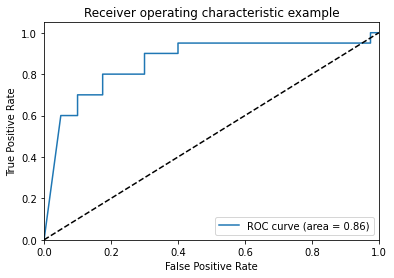

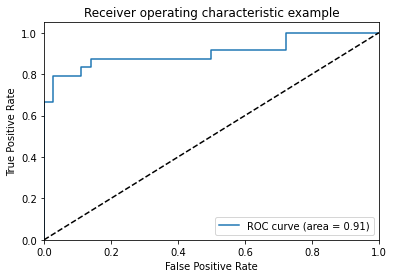

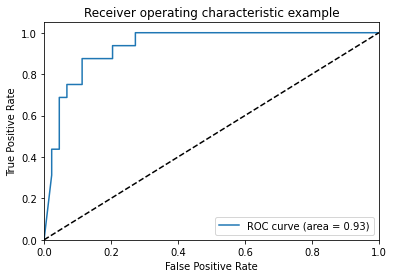

In [116]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [117]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)



0.8243476430976431

In [118]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[33  7]
  [ 6 14]]

 [[32  4]
  [ 4 20]]

 [[39  5]
  [ 3 13]]]
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.83      0.83      0.83        24
           2       0.72      0.81      0.76        16

   micro avg       0.75      0.78      0.76        60
   macro avg       0.74      0.78      0.76        60
weighted avg       0.75      0.78      0.76        60
 samples avg       0.77      0.78      0.77        60



In [119]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.7666666666666667


In [120]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.75
Hamming loss: 0.16111111111111112


In [121]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[14,  3,  3],
       [ 4, 19,  1],
       [ 3,  1, 12]])

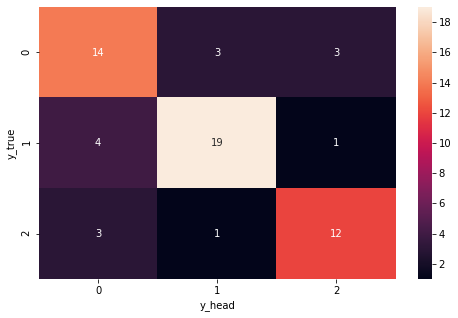

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [123]:
df_untagged = df_untagged.drop(['sentimen'], axis =1)
df_untagged

,username,comments
0,amsaff s,antara sinovac who cepi bill gates and melinda...
1,furink kucink,betul vaksin sinovac kah yang di suntikkan
2,fian rubianti,itu kalo udh disuntik vaksin sinovac nya masih...
3,saleh sj,benarkah dan kenapa bbrp negara lain byk yg me...
4,suhudan nasution,pak tolong d vaksin lebih dulu sabu janda deny...
5,evy avrianty,dokter2 dunia mengatakan vaksinsinovacpfizermo...
6,iwan ris,dichina aja sinovac ga d pakeko malah di pake ...
7,holidy bilal alki,ini ril modus koruptor beli faxin sinovax
8,hero hero,mengapa vaksin sinovac sudah disuntikkan kepad...
9,jeka chenel,ada yg janggal dgn berita ini vaksin sinovak ...


In [125]:
#ilangin link dan uname
df_untagged["comments"]=df_untagged["comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df_untagged["comments"]=df_untagged["comments"].str.lower()
#ilangin simbol
df_untagged["comments"]=df_untagged["comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df_untagged["comments"]=df_untagged["comments"].str.replace('\d+',' ')
#ilangin enter
df_untagged["comments"]=df_untagged["comments"].str.replace('\n',' ',regex=True)
df_untagged["comments"] = df_untagged["comments"].replace('\s+', ' ', regex=True)
df_untagged

,username,comments
0,amsaff s,antara sinovac who cepi bill gates and melinda...
1,furink kucink,betul vaksin sinovac kah yang di suntikkan
2,fian rubianti,itu kalo udh disuntik vaksin sinovac nya masih...
3,saleh sj,benarkah dan kenapa bbrp negara lain byk yg me...
4,suhudan nasution,pak tolong d vaksin lebih dulu sabu janda deny...
5,evy avrianty,dokter dunia mengatakan vaksinsinovacpfizermod...
6,iwan ris,dichina aja sinovac ga d pakeko malah di pake ...
7,holidy bilal alki,ini ril modus koruptor beli faxin sinovax
8,hero hero,mengapa vaksin sinovac sudah disuntikkan kepad...
9,jeka chenel,ada yg janggal dgn berita ini vaksin sinovak s...


In [127]:
list_sentences_aplikasi = df_untagged["comments"]
list_tokenized_aplikasi = tokenizer.texts_to_sequences(list_sentences_aplikasi)
X_aplikasi = pad_sequences(list_tokenized_aplikasi, maxlen=maxlen)
X_aplikasi

array([[   0,    0,    0, ...,  749, 1429,  295],
       [   0,    0,    0, ...,   10,    3, 1307],
       [   0,    0,    0, ...,  613,   33,  238],
       ...,
       [   0,    0,    0, ...,  778,    7,  124],
       [   0,    0,    0, ..., 1139,   55,  121],
       [   0,    0,    0, ...,  208,   77,  127]], dtype=int32)

In [128]:
y_pred_aplikasi = model.predict(X_aplikasi)
y_pred_aplikasi


array([[4.82212537e-09, 9.87531168e-10, 1.00000000e+00],
       [1.16397105e-05, 4.04721081e-01, 5.95267296e-01],
       [9.98803616e-01, 4.34216461e-04, 7.62200798e-04],
       [9.95725863e-11, 1.16925020e-11, 1.00000000e+00],
       [2.11931001e-06, 1.00357465e-06, 9.99996901e-01],
       [2.64030322e-02, 9.37336862e-01, 3.62601578e-02],
       [6.34228736e-02, 4.02953083e-05, 9.36536789e-01],
       [3.12876626e-04, 3.93389018e-05, 9.99647737e-01],
       [2.59806775e-03, 2.33317885e-04, 9.97168601e-01],
       [6.66640658e-12, 2.41562415e-08, 1.00000000e+00],
       [8.21273657e-04, 2.88292408e-01, 7.10886359e-01],
       [5.36786377e-01, 4.62655306e-01, 5.58282598e-04],
       [1.00000000e+00, 1.62417169e-09, 7.20370341e-09],
       [2.43159093e-08, 8.68284733e-09, 1.00000000e+00],
       [1.29862119e-11, 9.47281489e-12, 1.00000000e+00],
       [7.73528533e-04, 2.10731290e-03, 9.97119188e-01],
       [3.09439123e-01, 5.03535615e-03, 6.85525537e-01],
       [1.07069609e-04, 1.27250

In [129]:
dfhasil = pd.DataFrame(y_pred_aplikasi, columns=['POS', 'NET', 'NEG'])
dfhasil

,POS,NET,NEG
0,4.822125e-09,9.875312e-10,1.000000e+00
1,1.163971e-05,4.047211e-01,5.952673e-01
2,9.988036e-01,4.342165e-04,7.622008e-04
3,9.957259e-11,1.169250e-11,1.000000e+00
4,2.119310e-06,1.003575e-06,9.999969e-01
5,2.640303e-02,9.373369e-01,3.626016e-02
6,6.342287e-02,4.029531e-05,9.365368e-01
7,3.128766e-04,3.933890e-05,9.996477e-01
8,2.598068e-03,2.333179e-04,9.971686e-01
9,6.666407e-12,2.415624e-08,1.000000e+00


In [130]:
dfhasilramal = dfhasil.eq(dfhasil.where(dfhasil != 0).max(1), axis=0).astype(int)
dfhasilramal

,POS,NET,NEG
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


In [131]:
finalresult = pd.concat([df_untagged, dfhasilramal], axis=1, sort=False)
finalresult

,username,comments,POS,NET,NEG
0,amsaff s,antara sinovac who cepi bill gates and melinda...,0,0,1
1,furink kucink,betul vaksin sinovac kah yang di suntikkan,0,0,1
2,fian rubianti,itu kalo udh disuntik vaksin sinovac nya masih...,1,0,0
3,saleh sj,benarkah dan kenapa bbrp negara lain byk yg me...,0,0,1
4,suhudan nasution,pak tolong d vaksin lebih dulu sabu janda deny...,0,0,1
5,evy avrianty,dokter dunia mengatakan vaksinsinovacpfizermod...,0,1,0
6,iwan ris,dichina aja sinovac ga d pakeko malah di pake ...,0,0,1
7,holidy bilal alki,ini ril modus koruptor beli faxin sinovax,0,0,1
8,hero hero,mengapa vaksin sinovac sudah disuntikkan kepad...,0,0,1
9,jeka chenel,ada yg janggal dgn berita ini vaksin sinovak s...,0,0,1


In [132]:
finalresult.POS.value_counts()

0    24
1     3
Name: POS, dtype: int64

In [133]:
finalresult.NET.value_counts()

0    25
1     2
Name: NET, dtype: int64

In [134]:
finalresult.NEG.value_counts()

1    22
0     5
Name: NEG, dtype: int64

#Vaksin GRU-SGD

In [181]:
df = pd.read_excel('/content/drive/MyDrive/Vaksin_MiningYoutubeconcat_preprocess3_6Juli EXCEL.xlsx')
df = df[~df['comments'].isnull()]
df = df.reset_index()
df = df.drop(['index'], axis=1)
df['sentimen']= df['sentimen'].fillna(4)
df_untagged = df[df['sentimen'] == 4]
df = df[df['sentimen'] != 4]
df

,username,comments,sentimen
0,gaza ilyas,mati karena vaksin bukan karena vaksin mati ...,-1.0
1,hehe boay,tanpa vaksin disini aman,-1.0
2,c s,secara logika kalau hanya punya penyakit yang ...,-1.0
3,san 87,di kampung saya nganjuk 1 orang meninggal bany...,-1.0
4,nur han,apakah semua orang punya rekam medis yg teratu...,0.0
...,...,...,...
296,andini jani,dmn tanggung jawab pemerintah,-1.0
297,azifa arin,kalo sdh skit jgn d kasih vaksin,1.0
298,paniah mujiati,saya sudah 2x vaksin biontech,1.0
299,comberan chanel,dari seluruh komen semua sependapatsatu perasa...,0.0


In [182]:
df_untagged = df_untagged.reset_index()
df_untagged = df_untagged.drop(['index'], axis=1)
df_untagged

,username,comments,sentimen
0,sam sam,katanya tubuh akn kebal bila di vaksin ko mlh ...,4.0
1,seleb viral,eeaaaaaaa makin seru terus yg meninggal karn...,4.0
2,hilman alim,hadeuh pa ko dianggap rakyat indonesia nie bo...,4.0
3,irsyad alby ramadhan,malah jadi takut klo di vaksin,4.0
4,sari agusdarmoko,sing jelas ambekane entek,4.0
...,...,...,...
5697,gatot wewet,propaganda,4.0
5698,ekak anang,bagi yang tidak mau vaksin za monggosilahkan t...,4.0
5699,sudarti soenari,awalnya corona dr cina obtnya juga dr cinaduni...,4.0
5700,mhd ikyraa,mending dikasi beras atau makanan dri pada vak...,4.0


In [183]:
print(df.sentimen.value_counts())

-1.0    235
 0.0     50
 1.0     16
Name: sentimen, dtype: int64


In [184]:
df['POS']= np.where(df['sentimen'] == 1, '1', '0')
df['NET']= np.where(df['sentimen'] == 0, '1', '0')
df['NEG']= np.where(df['sentimen'] == -1, '1', '0')
df = df.drop(['sentimen'], axis=1)
df

,username,comments,POS,NET,NEG
0,gaza ilyas,mati karena vaksin bukan karena vaksin mati ...,0,0,1
1,hehe boay,tanpa vaksin disini aman,0,0,1
2,c s,secara logika kalau hanya punya penyakit yang ...,0,0,1
3,san 87,di kampung saya nganjuk 1 orang meninggal bany...,0,0,1
4,nur han,apakah semua orang punya rekam medis yg teratu...,0,1,0
...,...,...,...,...,...
296,andini jani,dmn tanggung jawab pemerintah,0,0,1
297,azifa arin,kalo sdh skit jgn d kasih vaksin,1,0,0
298,paniah mujiati,saya sudah 2x vaksin biontech,1,0,0
299,comberan chanel,dari seluruh komen semua sependapatsatu perasa...,0,1,0


In [185]:
#ilangin link dan uname
df["comments"]=df["comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df["comments"]=df["comments"].str.lower()
#ilangin simbol
df["comments"]=df["comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df["comments"]=df["comments"].str.replace('\d+',' ')
#ilangin enter
df["comments"]=df["comments"].str.replace('\n',' ',regex=True)
df["comments"] = df["comments"].replace('\s+', ' ', regex=True)
df

,username,comments,POS,NET,NEG
0,gaza ilyas,mati karena vaksin bukan karena vaksin mati ka...,0,0,1
1,hehe boay,tanpa vaksin disini aman,0,0,1
2,c s,secara logika kalau hanya punya penyakit yang ...,0,0,1
3,san 87,di kampung saya nganjuk orang meninggal banyak...,0,0,1
4,nur han,apakah semua orang punya rekam medis yg teratu...,0,1,0
...,...,...,...,...,...
296,andini jani,dmn tanggung jawab pemerintah,0,0,1
297,azifa arin,kalo sdh skit jgn d kasih vaksin,1,0,0
298,paniah mujiati,saya sudah x vaksin biontech,1,0,0
299,comberan chanel,dari seluruh komen semua sependapatsatu perasa...,0,1,0


In [186]:
df_majority = df[df.POS== '0' ]

df_minority = df[df.POS== '1']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=235,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.NET== '0' ]

df_minority_2 = df_upsampled[df_upsampled.NET== '1']

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=235,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
df = df_upsampled_2
print(df.POS.value_counts())
print(df.NET.value_counts())
print(df.NEG.value_counts())

0    470
1    235
Name: POS, dtype: int64
0    470
1    235
Name: NET, dtype: int64
0    470
1    235
Name: NEG, dtype: int64


In [187]:
df['POS']=df['POS'].astype(int)
df['NET']=df['NET'].astype(int)
df['NEG']=df['NEG'].astype(int)
train, test = train_test_split(df, test_size=0.2, random_state = 23)
list_classes = ['POS','NET','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["comments"]
list_sentences_test = test["comments"]
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [188]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [189]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [190]:
word_vectors = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/model300.bin",binary="True", unicode_errors='ignore')
word2vec = word_vectors
embed_dim = 300

In [191]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

887 234
known words: 887
unknown words: 234


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [192]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
inp = Input(shape=(maxlen,))


In [193]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
#x = Bidirectional(LSTM(200, activation='tanh', return_sequences = True, dropout=0.4))(x)
x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.SGD(lr=0.01)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
18/18 - 7s - loss: 0.6836 - accuracy: 0.3706 - val_loss: 0.6436 - val_accuracy: 0.3404

 ROC-AUC - epoch: 1 - score: 0.533823 

Epoch 2/100
18/18 - 3s - loss: 0.6438 - accuracy: 0.3972 - val_loss: 0.6231 - val_accuracy: 0.4043

 ROC-AUC - epoch: 2 - score: 0.619643 

Epoch 3/100
18/18 - 3s - loss: 0.6220 - accuracy: 0.4734 - val_loss: 0.5997 - val_accuracy: 0.4681

 ROC-AUC - epoch: 3 - score: 0.675982 

Epoch 4/100
18/18 - 3s - loss: 0.6040 - accuracy: 0.5000 - val_loss: 0.5829 - val_accuracy: 0.5177

 ROC-AUC - epoch: 4 - score: 0.717915 

Epoch 5/100
18/18 - 3s - loss: 0.5813 - accuracy: 0.5195 - val_loss: 0.5675 - val_accuracy: 0.5674

 ROC-AUC - epoch: 5 - score: 0.747147 

Epoch 6/100
18/18 - 3s - loss: 0.5703 - accuracy: 0.5585 - val_loss: 0.5554 - val_accuracy: 0.5957

 ROC-AUC - epoch: 6 - score: 0.753329 

Epoch 7/100
18/18 - 3s - loss: 0.5549 - accuracy: 0.5514 - val_loss: 0.5366 - val_accuracy: 0.5957

 ROC-AUC - epoch: 7 - score: 0.777924 

Epoch 8/100
18/18 - 

In [194]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 50, 300)           336600    
_________________________________________________________________
gru_4 (GRU)                  (None, 50, 200)           301200    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 200)               0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0   

In [195]:
from keras.models import load_model
c = model.predict(X_te)

In [196]:

score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 48ms/step - loss: 0.1453 - accuracy: 0.8865
Test accuracy: 0.8865247964859009


In [197]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.9978502265845033

In [198]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

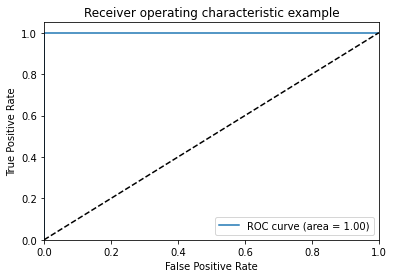

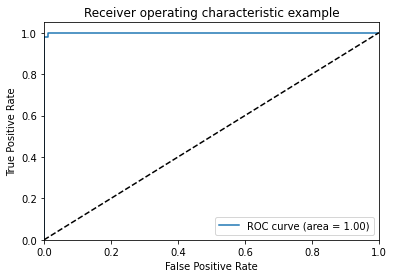

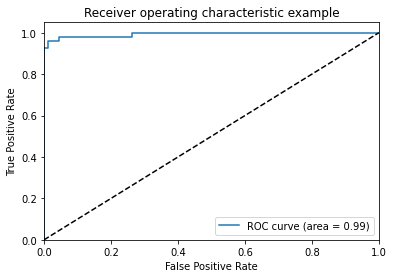

In [199]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [200]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)


0.9385970189962777

In [201]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[92  6]
  [ 0 43]]

 [[81 15]
  [ 0 45]]

 [[88  0]
  [ 8 45]]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        43
           1       0.75      1.00      0.86        45
           2       1.00      0.85      0.92        53

   micro avg       0.86      0.94      0.90       141
   macro avg       0.88      0.95      0.90       141
weighted avg       0.88      0.94      0.90       141
 samples avg       0.90      0.94      0.91       141



In [202]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.900709219858156


In [203]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.8581560283687943
Hamming loss: 0.06855791962174941


In [204]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[43,  0,  0],
       [ 0, 45,  0],
       [ 6, 14, 33]])

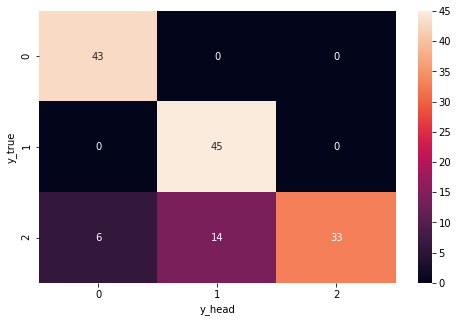

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

#Vaksin LSTM-ADAM

In [167]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = LSTM(200, activation='tanh', return_sequences = True, dropout=0.4)(x)
#x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="softmax")(x)


model = Model(inputs=inp, outputs=x)
opt = optimizers.Adam(lr=0.001)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 32
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
18/18 - 9s - loss: 0.6382 - accuracy: 0.4238 - val_loss: 0.5713 - val_accuracy: 0.4894

 ROC-AUC - epoch: 1 - score: 0.822052 

Epoch 2/100
18/18 - 5s - loss: 0.5170 - accuracy: 0.5993 - val_loss: 0.5550 - val_accuracy: 0.4539

 ROC-AUC - epoch: 2 - score: 0.833379 

Epoch 3/100
18/18 - 5s - loss: 0.3864 - accuracy: 0.7323 - val_loss: 0.3953 - val_accuracy: 0.6241

 ROC-AUC - epoch: 3 - score: 0.888666 

Epoch 4/100
18/18 - 5s - loss: 0.2914 - accuracy: 0.8085 - val_loss: 0.2727 - val_accuracy: 0.8156

 ROC-AUC - epoch: 4 - score: 0.966516 

Epoch 5/100
18/18 - 5s - loss: 0.2168 - accuracy: 0.8777 - val_loss: 0.2133 - val_accuracy: 0.8652

 ROC-AUC - epoch: 5 - score: 0.963655 

Epoch 6/100
18/18 - 5s - loss: 0.1466 - accuracy: 0.9255 - val_loss: 0.1418 - val_accuracy: 0.9149

 ROC-AUC - epoch: 6 - score: 0.985785 

Epoch 7/100
18/18 - 5s - loss: 0.0952 - accuracy: 0.9521 - val_loss: 0.0664 - val_accuracy: 0.9716

 ROC-AUC - epoch: 7 - score: 0.998739 

Epoch 8/100
18/18 - 

In [168]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 50, 300)           336600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 200)           400800    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 200)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0   

In [169]:
from keras.models import load_model
c = model.predict(X_te)

In [170]:
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

5/5 [==============================] - 0s 52ms/step - loss: 0.3054 - accuracy: 0.8794
Test accuracy: 0.8794326186180115


In [171]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

1.0

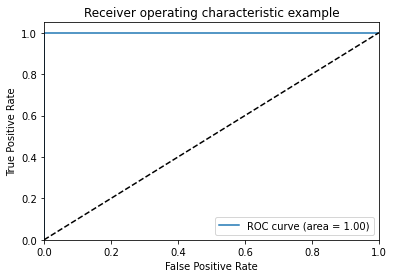

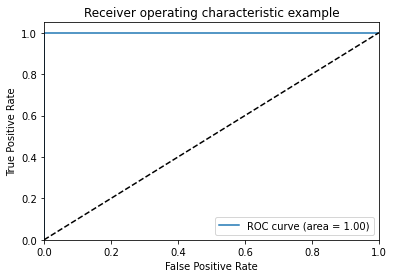

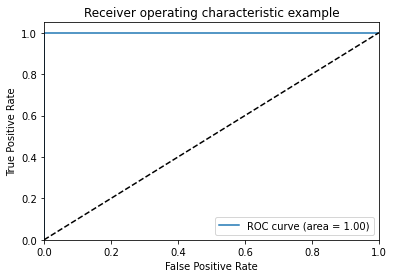

In [172]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [173]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)



0.9186126887862063

In [174]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[93  5]
  [ 0 43]]

 [[83 13]
  [ 0 45]]

 [[88  0]
  [16 37]]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        43
           1       0.78      1.00      0.87        45
           2       1.00      0.70      0.82        53

   micro avg       0.87      0.89      0.88       141
   macro avg       0.89      0.90      0.88       141
weighted avg       0.90      0.89      0.88       141
 samples avg       0.88      0.89      0.88       141



In [175]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.8829787234042553


In [176]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.8794326241134752
Hamming loss: 0.08037825059101655


In [177]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[43,  0,  0],
       [ 0, 45,  0],
       [ 5, 12, 36]])

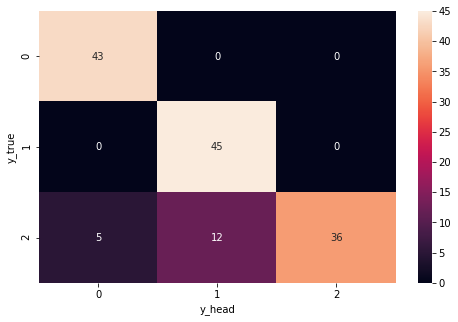

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [206]:
df_untagged = df_untagged.drop(['sentimen'], axis =1)
df_untagged

,username,comments
0,sam sam,katanya tubuh akn kebal bila di vaksin ko mlh ...
1,seleb viral,eeaaaaaaa makin seru terus yg meninggal karn...
2,hilman alim,hadeuh pa ko dianggap rakyat indonesia nie bo...
3,irsyad alby ramadhan,malah jadi takut klo di vaksin
4,sari agusdarmoko,sing jelas ambekane entek
...,...,...
5697,gatot wewet,propaganda
5698,ekak anang,bagi yang tidak mau vaksin za monggosilahkan t...
5699,sudarti soenari,awalnya corona dr cina obtnya juga dr cinaduni...
5700,mhd ikyraa,mending dikasi beras atau makanan dri pada vak...


In [207]:
#ilangin link dan uname
df_untagged["comments"]=df_untagged["comments"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df_untagged["comments"]=df_untagged["comments"].str.lower()
#ilangin simbol
df_untagged["comments"]=df_untagged["comments"].str.replace('[^\w\s]',' ')
#ilangin angka
df_untagged["comments"]=df_untagged["comments"].str.replace('\d+',' ')
#ilangin enter
df_untagged["comments"]=df_untagged["comments"].str.replace('\n',' ',regex=True)
df_untagged["comments"] = df_untagged["comments"].replace('\s+', ' ', regex=True)
df_untagged

,username,comments
0,sam sam,katanya tubuh akn kebal bila di vaksin ko mlh ...
1,seleb viral,eeaaaaaaa makin seru terus yg meninggal karna ...
2,hilman alim,hadeuh pa ko dianggap rakyat indonesia nie bo...
3,irsyad alby ramadhan,malah jadi takut klo di vaksin
4,sari agusdarmoko,sing jelas ambekane entek
...,...,...
5697,gatot wewet,propaganda
5698,ekak anang,bagi yang tidak mau vaksin za monggosilahkan t...
5699,sudarti soenari,awalnya corona dr cina obtnya juga dr cinaduni...
5700,mhd ikyraa,mending dikasi beras atau makanan dri pada vak...


In [211]:
df_untagged.comments = df_untagged.comments.astype(str)
df_untagged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5702 entries, 0 to 5701
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  5700 non-null   object
 1   comments  5702 non-null   object
dtypes: object(2)
memory usage: 89.2+ KB


In [212]:
list_sentences_aplikasi = df_untagged["comments"]
list_tokenized_aplikasi = tokenizer.texts_to_sequences(list_sentences_aplikasi)
X_aplikasi = pad_sequences(list_tokenized_aplikasi, maxlen=maxlen)
X_aplikasi

array([[   0,    0,    0, ...,  170,  846,    1],
       [   0,    0,    0, ...,    2,  163,  236],
       [   0,    0,    0, ...,  320,  380, 1033],
       ...,
       [   0,    0,    0, ..., 1061,  476,  483],
       [   0,    0,    0, ...,  177,    1,  967],
       [   0,    0,    0, ...,  192,  225,    2]], dtype=int32)

In [213]:
y_pred_aplikasi = model.predict(X_aplikasi)
y_pred_aplikasi


array([[1.0545164e-02, 6.9841743e-04, 9.9458635e-01],
       [5.7014586e-05, 8.1840158e-03, 9.9869698e-01],
       [5.8987737e-03, 2.9518348e-01, 6.2702256e-01],
       ...,
       [6.2263012e-04, 1.3435793e-01, 9.2821944e-01],
       [1.0047972e-02, 4.1880012e-03, 9.8192996e-01],
       [6.1622262e-03, 3.9420536e-01, 6.0775638e-01]], dtype=float32)

In [ ]:
dfhasil = pd.DataFrame(y_pred_aplikasi, columns=['POS', 'NET', 'NEG'])
dfhasil

,POS,NET,NEG
0,4.822125e-09,9.875312e-10,1.000000e+00
1,1.163971e-05,4.047211e-01,5.952673e-01
2,9.988036e-01,4.342165e-04,7.622008e-04
3,9.957259e-11,1.169250e-11,1.000000e+00
4,2.119310e-06,1.003575e-06,9.999969e-01
5,2.640303e-02,9.373369e-01,3.626016e-02
6,6.342287e-02,4.029531e-05,9.365368e-01
7,3.128766e-04,3.933890e-05,9.996477e-01
8,2.598068e-03,2.333179e-04,9.971686e-01
9,6.666407e-12,2.415624e-08,1.000000e+00


In [214]:
dfhasilramal = dfhasil.eq(dfhasil.where(dfhasil != 0).max(1), axis=0).astype(int)
dfhasilramal

,POS,NET,NEG
0,0,0,1
1,0,0,1
2,1,0,0
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,0,0,1
8,0,0,1
9,0,0,1


In [215]:
finalresult = pd.concat([df_untagged, dfhasilramal], axis=1, sort=False)
finalresult

,username,comments,POS,NET,NEG
0,sam sam,katanya tubuh akn kebal bila di vaksin ko mlh ...,0.0,0.0,1.0
1,seleb viral,eeaaaaaaa makin seru terus yg meninggal karna ...,0.0,0.0,1.0
2,hilman alim,hadeuh pa ko dianggap rakyat indonesia nie bo...,1.0,0.0,0.0
3,irsyad alby ramadhan,malah jadi takut klo di vaksin,0.0,0.0,1.0
4,sari agusdarmoko,sing jelas ambekane entek,0.0,0.0,1.0
...,...,...,...,...,...
5697,gatot wewet,propaganda,NaN,NaN,NaN
5698,ekak anang,bagi yang tidak mau vaksin za monggosilahkan t...,NaN,NaN,NaN
5699,sudarti soenari,awalnya corona dr cina obtnya juga dr cinaduni...,NaN,NaN,NaN
5700,mhd ikyraa,mending dikasi beras atau makanan dri pada vak...,NaN,NaN,NaN


In [216]:
finalresult.POS.value_counts()

0.0    24
1.0     3
Name: POS, dtype: int64

In [218]:
finalresult.NET.value_counts()

0.0    25
1.0     2
Name: NET, dtype: int64

In [219]:
finalresult.NEG.value_counts()

1.0    22
0.0     5
Name: NEG, dtype: int64